# TP 1.2 Variational Autoencoders on Fashion MNIST

## Import

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data preparation

- **Why do we pad the images from 28×28 to 32×32?**  
  - Ensures compatibility with common CNN architectures that work best with power-of-2 spatial dimensions, reducing information loss during downsampling.

> Add blockquote



- **Which transformations can help (e.g., normalization)?**  
  - **Normalization (e.g., mean=0.5, std=0.5)**: Speeds up convergence.  
  - **Data augmentation (e.g., random flips, rotations)**: Increases generalization

- **How do we shuffle and batch the data for efficient training?**  
  - **Shuffling**: Prevents model from memorizing order-specific patterns.  
  - **Batching**: Allows parallelized GPU computation, improving training speed and stability.  

In [85]:
transform = transforms.Compose([
    transforms.Pad(2),    # from 28x28 to 32x32
    transforms.ToTensor() # convert images to tensors
])

batch_size = 128

# Training set
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Validation set
val_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

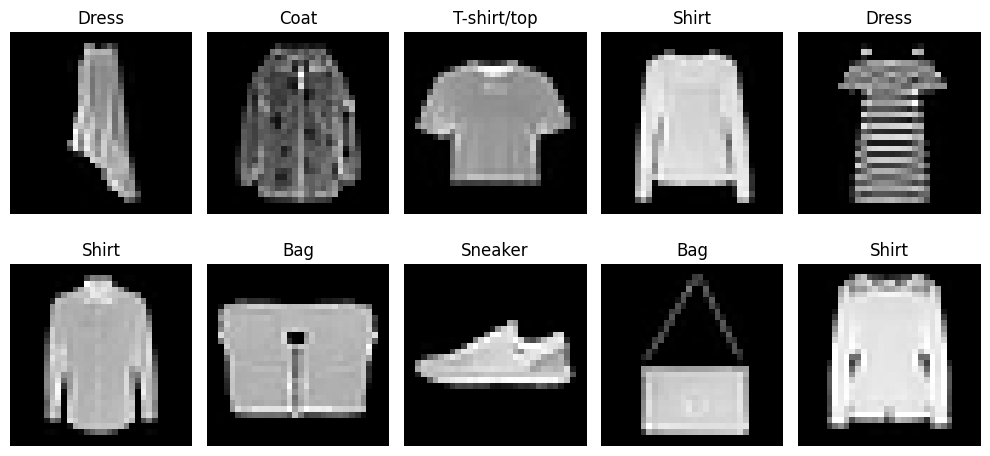

In [86]:
class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}


def plot_sample_images(loader):
    """
    Display a few sample images from the DataLoader.
    """
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(class_labels[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(train_loader)


## Define the VAE Model

- **Why do we need separate heads for μ and log(σ²)?**  
  - Allows the model to learn both the mean (μ) and variance (σ²) of the latent distribution, enforcing a probabilistic representation rather than a deterministic one.  

- **How does the reparameterization trick help with backpropagation through stochastic nodes?**  
  - Avoids direct sampling from a non-differentiable stochastic distribution. Instead, it reformulates z = μ + σ × ε (with ε ~ N(0,1)), making gradient-based optimization possible.  

In [87]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Variational Autoencoder initialization.

        Args:
            input_shape (tuple): Shape of the input image. Default is (1, 32, 32).
            latent_dim (int): Dimension of the latent representation.
        """
        super(VAE, self).__init__()

        # ------------------
        #     1. Encoder
        # ------------------
        # This block progressively reduces the spatial dimension of the input.
        # Each Conv2D layer uses stride=2 to downsample.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )

        # Dynamically calculate the flattened size after all convolution layers
        flattened_size, decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # ------------------------------------------------
        #     2. Fully Connected Layers for Latent Space
        # ------------------------------------------------

        # Two separate heads for the VAE:
        #  - fc_mu: Predicts the mean of the latent distribution
        #  - fc_logvar: Predicts the log-variance of the latent distribution
        self.fc_mu = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent mean
        )
        self.fc_logvar = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent log variance (Hint: same dimension as mu)
        )

        # ------------------
        #     3. Decoder
        # ------------------
        # Inverts the encoder process with ConvTranspose2d (a.k.a. deconvolutions).
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),
            nn.Unflatten(dim=1, unflattened_size=decode_shape[1:]),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # outputs between 0 and 1
        )
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick:

        z = mu + sigma * eps, where eps ~ N(0, I)

        Args:
            mu (Tensor): Mean of the latent distribution.
            logvar (Tensor): Log-variance of the latent distribution.

        Returns:
            z (Tensor): Latent variable sampled from N(mu, sigma^2).
        """
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)    # Sample noise from a normal distribution
        return mu + std * eps

    def calculate_flattened_size(self, model, input_shape):
       #same as the last one
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = model(dummy_input)
            return output.numel(), output.shape

    def forward(self, x):
        """
        Forward pass for the VAE:

        1) Encode input into latent distribution parameters (mu, logvar).
        2) Sample z using the reparameterization trick.
        3) Decode z back to a reconstructed image.

        Args:
            x (Tensor): Input images.

        Returns:
            recon_x (Tensor): Reconstructed images.
            mu (Tensor): Mean of latent distribution.
            logvar (Tensor): Log-variance of latent distribution.
            z (Tensor): Sampled latent variable.
        """
        # Encode input
        x_encoded = self.encoder(x)

        # Compute mu and logvar
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)

        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)

        # Decode latent vector to reconstruct the input
        recon_x = self.decoder(z)

        return recon_x, mu, logvar, z


In [88]:
# Test dimension consistency
x_sample = torch.randn(1, 1, 32, 32)  # Example input
model_test = VAE(latent_dim=2)
image_test, mu, logvar, z = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Output dimensions do not match input dimensions!"

## VAE Loss Function and Training

- **How does a larger β value change the trade-off between reconstruction quality and latent disentanglement?**  
  - Higher β (β > 1): Increases focus on KL divergence, encouraging more structured latent space (better disentanglement) but at the cost of worse reconstruction quality.  
  - Lower β (β ≈ 1): Balances reconstruction and regularization, yielding realistic reconstructions while maintaining a structured latent space.  
  - Very low β (β < 1): Prioritizes reconstruction, potentially causing overfitting and poor generalization.  

In [89]:
#######################
# 1. Define VAE Loss
#######################
def vae_loss(recon_x, x, mu, logvar, beta=1):
    """
    Compute the Variational Autoencoder (VAE) loss function.
    A combination of:
      - Reconstruction loss (using BCE or MSE)
      - KL divergence regularizer

    Args:
      recon_x (Tensor): Reconstructed images from the decoder.
      x (Tensor): Original input images.
      mu (Tensor): Mean of the latent distribution.
      logvar (Tensor): Log-variance of the latent distribution.
      beta (float): Weight for the KL term (β-VAE concept).

    Returns:
      total_loss (Tensor): Sum of reconstruction loss and β * KL divergence.
    """

    # 1) Reconstruction Loss
    #    Measures how closely recon_x matches x.
    #    Typically use Binary Cross Entropy (BCE) if inputs are normalized [0,1].
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')


    # 2) KL Divergence
    #    Encourages the approximate posterior (q(z|x)) to be close to a
    #    standard normal prior p(z) ~ N(0,I).
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Return the total VAE loss
    return recon_loss + beta * kl_div

We add evaluation function before training because u use some evaluation functions in training

In [90]:
#######################
# 3. Evaluation Function
#######################
def evaluate_model(model, loader ,beta=1.0):
    """
    Evaluates the VAE on a validation or test dataset.

    Args:
      model (nn.Module): VAE instance (encoder + decoder).
      loader (DataLoader): Dataloader for validation/test set.

    Returns:
      avg_loss (float): Average loss across all validation samples.
      ce_loss_placeholder (float): Placeholder if you want to track
                                   additional metrics or losses.
beta (float): Weight for the KL divergence in the VAE loss.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    ce_loss_placeholder = 0  # Example placeholder for separate metrics

    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to(device)  # Move data to the same device as the model

            # Forward pass to get reconstruction and latent variables
            recon_x, mu, logvar, _ = model(x)

            # Compute VAE loss (without adjusting gradients)
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)  # e.g., same β as training

            total_loss += loss.item()
            # Optionally compute or track other metrics here, e.g.:
            # ce_loss_placeholder += some_other_metric(...)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, ce_loss_placeholder

def plot_training_loss(train_losses, val_losses):
    """
    Plot the training and validation loss across epochs.

    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [91]:
#######################
# 2. Training Function
#######################
def train_model(model, train_loader, val_loader, epochs, beta=1):
    """
    Trains a VAE model with a given β for the KL term.

    Args:
      model (nn.Module): VAE instance (encoder + decoder).
      train_loader (DataLoader): Dataloader for training set.
      val_loader (DataLoader): Dataloader for validation set.
      epochs (int): Number of training epochs.
      beta (float): Weight for the KL divergence in the VAE loss.
    """

    # Choose an optimizer, e.g., Adam
    optimizer = optim.Adam(model.parameters(), lr=1e-4) # e.g., 1e-4
    # Lists to store loss values for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to train mode
        total_loss = 0

        # Use tqdm to create a progress bar
        tqdm_loader = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")

        for x, _ in tqdm_loader:
            # 1) Zero out gradients from previous iteration
            optimizer.zero_grad()

            # 2) Move the batch to the correct device (CPU, CUDA, or MPS)
            x = x.to(device)  # Fill in your device, e.g., device, "cuda", or "mps"

            # 3) Forward pass: encode -> reparameterize -> decode
            recon_x, mu, logvar, _ = model(x)

            # 4) Compute VAE loss
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)

            # 5) Backpropagation
            loss.backward()
            # 5) update grad
            optimizer.step()

            # Accumulate total loss for this batch
            total_loss += loss.item()

            # Update tqdm progress bar with the current batch loss
            tqdm_loader.set_postfix(loss=loss.item())

        # Average loss over all training samples
        avg_train_loss = total_loss / len(train_loader.dataset)

        # Evaluate on validation data
        avg_val_loss, _ = evaluate_model(model, val_loader)

        # Print epoch statistics
        print(
            f"Epoch [{epoch + 1}/{epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}"
        )
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    plot_training_loss(train_losses, val_losses)

Training Autoencoder...


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 46.17it/s]


Epoch [1/20], Train Loss: 429.7933, Val Loss: 318.3872


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 44.13it/s]


Epoch [2/20], Train Loss: 306.7953, Val Loss: 296.2358


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.24it/s]


Epoch [3/20], Train Loss: 293.8238, Val Loss: 288.1043


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.93it/s]


Epoch [4/20], Train Loss: 287.6365, Val Loss: 283.7281


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.58it/s]


Epoch [5/20], Train Loss: 283.7932, Val Loss: 280.6634


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.21it/s]


Epoch [6/20], Train Loss: 280.9540, Val Loss: 278.1780


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.31it/s]


Epoch [7/20], Train Loss: 278.7134, Val Loss: 276.1513


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.42it/s]


Epoch [8/20], Train Loss: 276.9479, Val Loss: 274.6172


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.79it/s]


Epoch [9/20], Train Loss: 275.5952, Val Loss: 273.4842


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 52.94it/s]


Epoch [10/20], Train Loss: 274.4104, Val Loss: 272.5356


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.17it/s]


Epoch [11/20], Train Loss: 273.5653, Val Loss: 271.5599


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 52.15it/s]


Epoch [12/20], Train Loss: 272.7857, Val Loss: 271.2430


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.43it/s]


Epoch [13/20], Train Loss: 272.1552, Val Loss: 270.5216


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.93it/s]


Epoch [14/20], Train Loss: 271.5837, Val Loss: 269.8409


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.31it/s]


Epoch [15/20], Train Loss: 271.1137, Val Loss: 269.3145


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.35it/s]


Epoch [16/20], Train Loss: 270.6979, Val Loss: 269.0806


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.34it/s]


Epoch [17/20], Train Loss: 270.2797, Val Loss: 268.7668


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.10it/s]


Epoch [18/20], Train Loss: 269.9140, Val Loss: 268.3033


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.31it/s]


Epoch [19/20], Train Loss: 269.6286, Val Loss: 268.2659


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 48.14it/s]


Epoch [20/20], Train Loss: 269.3051, Val Loss: 267.9346


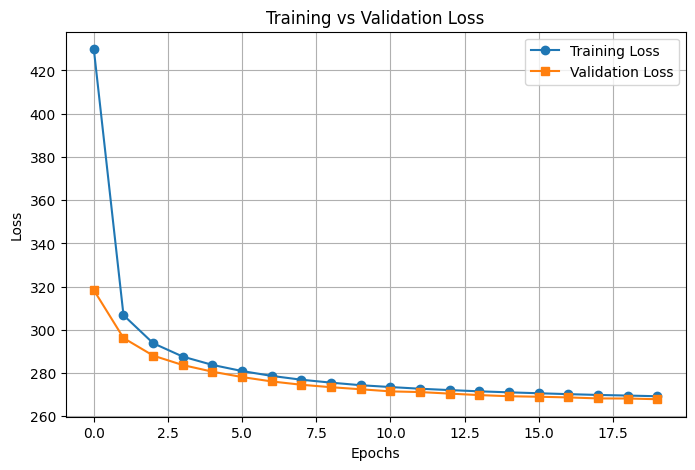

In [92]:
# Train and visualize Autoencoder
vae = VAE().to(device)
print("Training Autoencoder...")
train_model(vae, train_loader, val_loader, epochs=20,beta =1.5)

## Reconstruct Images

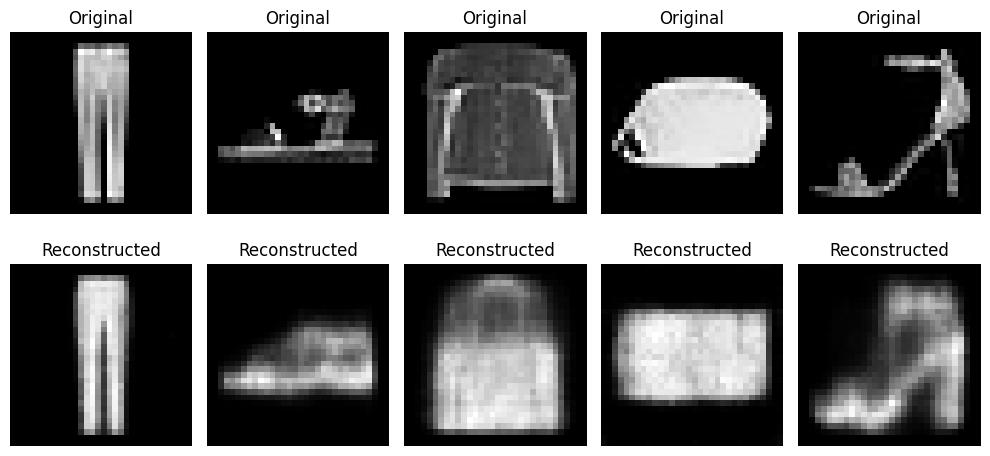

In [93]:
def plot_reconstructions(model, loader_or_z, ex=True, num_samples=5):
    """
    Plot original and reconstructed images from an Autoencoder (VAE).

    Parameters:
    - model: Trained VAE model.
    - loader_or_z: Either a DataLoader (for real images) or sampled latent vectors.
    - ex: If True, extracts a batch from DataLoader; otherwise, uses provided latent vectors.
    - num_samples: Number of images to display.

    """
    model.eval()  # Set model to evaluation mode
    model = model.to("cpu")  # Move to CPU for visualization

    with torch.no_grad():
        if ex:  # Extract batch from DataLoader
            for x, _ in loader_or_z:
                recon_x, _, _, _ = model(x)
                break
        else:  # Use provided latent vectors
            x = None  # No original images in this case
            recon_x = model.decoder(loader_or_z)

    # Convert tensors to NumPy for visualization
    if x is not None:
        x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        # Plot Original images (if real data was used)
        if x is not None:
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")

        # Plot Reconstructed images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_reconstructions( vae, train_loader, ex=True)




## Visualize the Latent Space

In [94]:
embeddings = []
labels = []

vae = vae.to(device)  # Replace xxx with the correct device
with torch.no_grad():
    for x, y in train_loader:  # Iterate over training batches

        x = x.to(device)


        recon_x, latent, logvar, z = vae(x)

        # Convert to NumPy and store results
        embeddings.append(latent.cpu().numpy())
        labels.append(y.numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Identify unique class labels
unique_labels = np.unique(labels)
vae=vae.to("cpu")

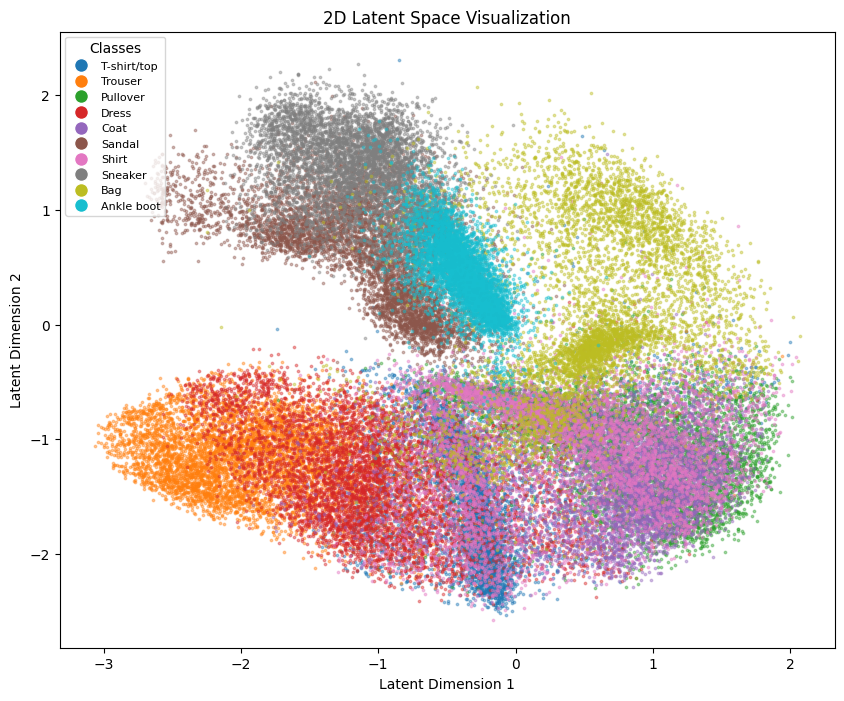

In [95]:
# Plot the 2D embeddings

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Scatter plot
plt.figure(figsize=(10, 8))
legend_handles = []
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0]
    scatter = plt.scatter(
        embeddings[indices, 0], embeddings[indices, 1],
        c=[colors[i]], alpha=0.4, s=3, label=class_labels[label]
    )
    legend_handles.append(
        Line2D([0], [0], marker='o', color='w', label=f'{class_labels[label]}',
               markersize=10, markerfacecolor=colors[i])
    )

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
plt.show()


tensor([[ 1.3889, -0.9275],
        [-0.4034,  0.7047],
        [-0.2794, -0.7585],
        [-0.2706, -1.9940],
        [ 0.0809,  0.1331]])


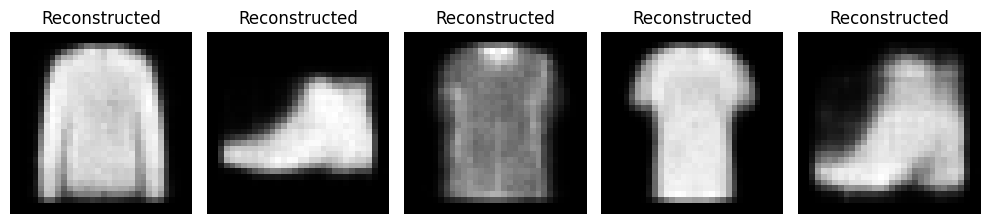

In [100]:
z_sample =  torch.tensor(np.random.normal(size=(5, 2)),dtype=torch.float32)
print(z_sample)
plot_reconstructions( vae, z_sample, ex=False)